# The GARCH Option Pricing Model

## Library Import

In [47]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import yfinance as yf 
from arch import arch_model
from arch.univariate import ARX, GARCH, StudentsT, SkewStudent, Normal
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## Importing Data: We are using AMD as it is currently volatile and makes for a good demo.

In [48]:
amd = yf.download("AMD", period="1y", interval="1d")

[*********************100%***********************]  1 of 1 completed


In [49]:
amd_close = amd.Close
amd_close

Date
2023-09-11    105.320000
2023-09-12    105.309998
2023-09-13    107.709999
2023-09-14    106.629997
2023-09-15    101.489998
                 ...    
2024-09-04    140.869995
2024-09-05    139.440002
2024-09-06    134.350006
2024-09-09    138.149994
2024-09-10    142.839996
Name: Close, Length: 252, dtype: float64

<Axes: xlabel='Date'>

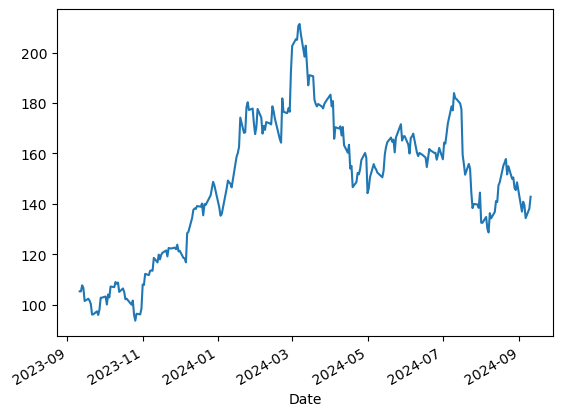

In [50]:
amd_close.plot.line()

## Calculating Log Return

In [51]:
amd_close_log_return = np.log(amd_close / amd_close.shift(1))

In [52]:
amd_close_log_return = amd_close_log_return.dropna()

<Axes: xlabel='Date'>

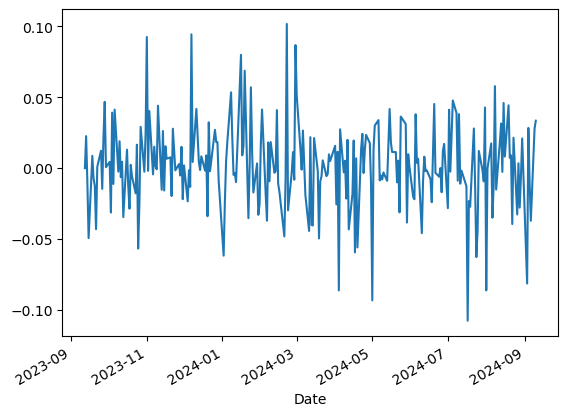

In [53]:
amd_close_log_return.plot.line()

## GJR-GARCH Model With Autoregressive Mean and Normal Residuals

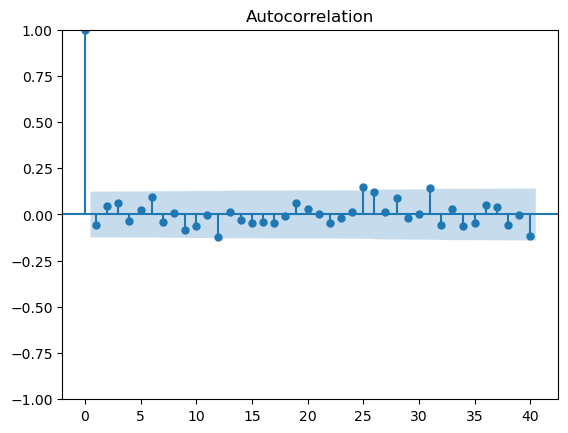

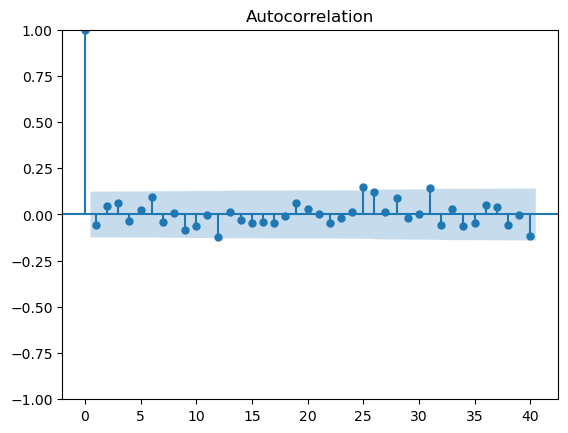

In [54]:
plot_acf(amd_close_log_return, lags=40)

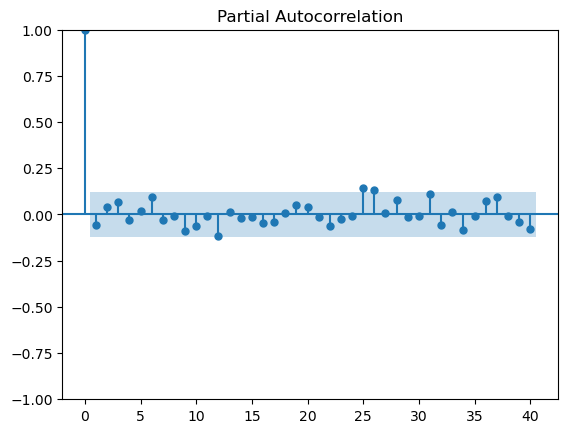

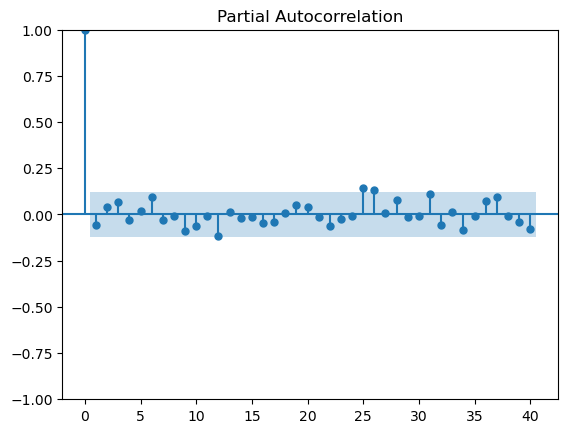

In [55]:
plot_pacf(amd_close_log_return, lags=40)

In [56]:
ar_gjr_normal = ARX(amd_close_log_return, lags=[1], rescale=True)
ar_gjr_normal.volatility = GARCH(p=1, o=1, q=1)
ar_gjr_normal.distribution = Normal()
res_gjr_normal = ar_gjr_normal.fit()

Iteration:      1,   Func. Count:      8,   Neg. LLF: 1008.388985714436
Iteration:      2,   Func. Count:     17,   Neg. LLF: 1000.5898906598811
Iteration:      3,   Func. Count:     26,   Neg. LLF: 632.2316355735063
Iteration:      4,   Func. Count:     33,   Neg. LLF: 632.4846908392631
Iteration:      5,   Func. Count:     42,   Neg. LLF: 632.2308288018259
Iteration:      6,   Func. Count:     49,   Neg. LLF: 632.2303941649675
Iteration:      7,   Func. Count:     56,   Neg. LLF: 632.2298988296436
Iteration:      8,   Func. Count:     63,   Neg. LLF: 632.2278319631232
Iteration:      9,   Func. Count:     70,   Neg. LLF: 632.223190679159
Iteration:     10,   Func. Count:     77,   Neg. LLF: 632.2207444170114
Iteration:     11,   Func. Count:     84,   Neg. LLF: 632.1709939309089
Iteration:     12,   Func. Count:     91,   Neg. LLF: 640.2278894547437
Iteration:     13,   Func. Count:     99,   Neg. LLF: 640.1595391089413
Iteration:     14,   Func. Count:    107,   Neg. LLF: 639.822980

In [57]:
res_gjr_normal.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         AR - GJR-GARCH Model Results                         
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.003
Mean Model:                        AR   Adj. R-squared:                 -0.001
Vol Model:                  GJR-GARCH   Log-Likelihood:               -631.128
Distribution:                  Normal   AIC:                           1274.26
Method:            Maximum Likelihood   BIC:                           1295.38
                                        No. Observations:                  250
Date:                Wed, Sep 11 2024   Df Residuals:                      248
Time:                        19:18:14   Df Model:                            2
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
Const          0.1473      0.190      0.777      0.437   [ -0.224,  0.519]
Close[1]      -0.0536  5.200e-02     -1.031      0.302 [ -0.156,4.828e-02]
                               Volatility Model                               
==============================================================================
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
omega           0.1063      0.178      0.598      0.550      [ -0.242,  0.455]
alpha[1]        0.0000  1.434e-02      0.000      1.000 [-2.810e-02,2.810e-02]
gamma[1]   -1.1608e-10  1.728e-02 -6.720e-09      1.000 [-3.386e-02,3.386e-02]
beta[1]         0.9902  2.568e-02     38.556      0.000      [  0.940,  1.040]
==============================================================================

Covariance estimator: robust
"""

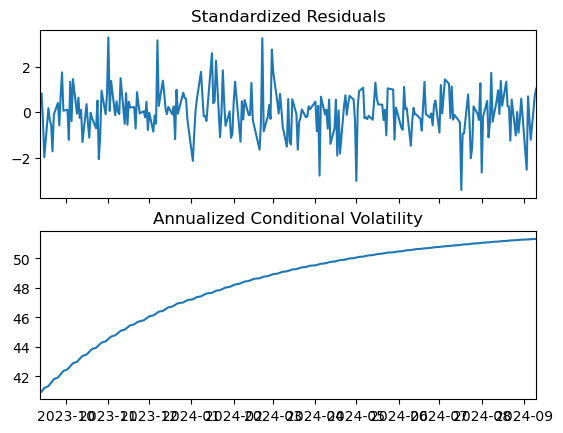

In [58]:
fig_gjr_normal = res_gjr_normal.plot(annualize="D")

## Model AIC

In [59]:
res_gjr_normal.aic

1274.2557463210246

## Model Scaling

In [60]:
res_gjr_normal.scale

100.0

## Forecasting Multi-Period Volatility

In [61]:
forecast_30 = res_gjr_normal.forecast(horizon=30)
forecast_30

In [62]:
forecast_30.variance

,h.01,h.02,h.03,h.04,h.05,h.06,h.07,h.08,h.09,h.10,...,h.21,h.22,h.23,h.24,h.25,h.26,h.27,h.28,h.29,h.30
Date,,,,,,,,,,,,,,,,,,,,,
2024-09-10,10.457363,10.490883,10.494385,10.497768,10.501117,10.504433,10.507716,10.510967,10.514187,10.517374,...,10.550434,10.553265,10.556069,10.558844,10.561593,10.564314,10.567008,10.569676,10.572318,10.574934


Rescaling the Variance.

In [63]:
forecast_30_variance_rescaled = forecast_30.variance / np.power(res_gjr_normal.scale, 2)

In [64]:
forecast_30_variance_rescaled

,h.01,h.02,h.03,h.04,h.05,h.06,h.07,h.08,h.09,h.10,...,h.21,h.22,h.23,h.24,h.25,h.26,h.27,h.28,h.29,h.30
Date,,,,,,,,,,,,,,,,,,,,,
2024-09-10,0.001046,0.001049,0.001049,0.00105,0.00105,0.00105,0.001051,0.001051,0.001051,0.001052,...,0.001055,0.001055,0.001056,0.001056,0.001056,0.001056,0.001057,0.001057,0.001057,0.001057


Annualizing Variance.

In [65]:
forecast_30_variance_annualized = forecast_30_variance_rescaled * np.sqrt(252 * 10)

In [66]:
forecast_30_variance_annualized

,h.01,h.02,h.03,h.04,h.05,h.06,h.07,h.08,h.09,h.10,...,h.21,h.22,h.23,h.24,h.25,h.26,h.27,h.28,h.29,h.30
Date,,,,,,,,,,,,,,,,,,,,,
2024-09-10,0.052496,0.052664,0.052681,0.052698,0.052715,0.052732,0.052748,0.052765,0.052781,0.052797,...,0.052963,0.052977,0.052991,0.053005,0.053019,0.053032,0.053046,0.053059,0.053073,0.053086


In [71]:
forecast_30_variance_annualized_transposed = pd.melt(forecast_30_variance_annualized.reset_index(),
                                          id_vars=['Date'], value_vars=forecast_30_variance_annualized.columns, 
                                            var_name='Day', value_name='Value')

In [73]:
forecast_30_variance_annualized_array = np.array(forecast_30_variance_annualized_transposed.Value)

In [74]:
forecast_30_variance_annualized_array

array([0.05249555, 0.05266381, 0.05268139, 0.05269837, 0.05271519,
       0.05273183, 0.05274832, 0.05276464, 0.0527808 , 0.0527968 ,
       0.05281264, 0.05282833, 0.05284387, 0.05285925, 0.05287448,
       0.05288956, 0.05290449, 0.05291927, 0.05293391, 0.05294841,
       0.05296276, 0.05297697, 0.05299104, 0.05300498, 0.05301877,
       0.05303243, 0.05304596, 0.05305935, 0.05307261, 0.05308575])

In [81]:
forecast_30_stddev_annualized_array = np.sqrt(forecast_30_variance_annualized_array)

In [83]:
forecast_30_stddev_annualized_array

array([0.22911907, 0.22948597, 0.22952428, 0.22956127, 0.22959788,
       0.22963413, 0.22967002, 0.22970555, 0.22974072, 0.22977554,
       0.22981002, 0.22984415, 0.22987794, 0.22991139, 0.22994451,
       0.2299773 , 0.23000976, 0.23004189, 0.23007371, 0.23010521,
       0.2301364 , 0.23016727, 0.23019784, 0.2302281 , 0.23025806,
       0.23028772, 0.23031709, 0.23034616, 0.23037494, 0.23040344])

## GARCH European Call Option Pricer

GBM Generator.

Call Option Price: 0.55


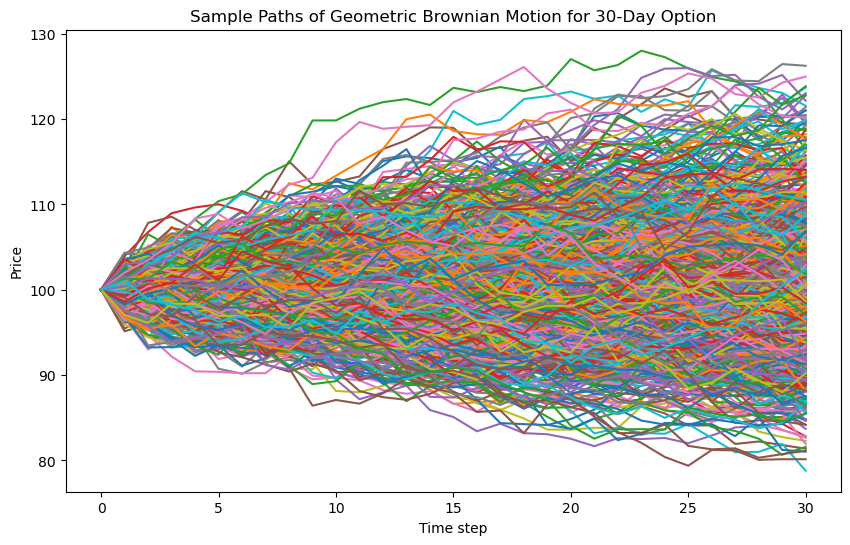

In [100]:
import numpy as np
import matplotlib.pyplot as plt

def GARCH_European_Call_MC(S0, r, sigma_arr, T, n, m, K):
    """
    Monte Carlo simulation for pricing a European call option using a time-varying volatility (sigma_arr).

    Parameters:
    - S0: Initial stock price
    - r: Risk-free interest rate
    - sigma_arr: Array of volatilities over time
    - T: Time to maturity
    - n: Number of time steps
    - m: Number of simulation paths
    - K: Strike price

    Returns:
    - call_price: Estimated call option price
    - gbm_paths: Simulated stock price paths
    """
    dt = T / n  
    gbm_paths = np.zeros((m, n + 1))
    gbm_paths[:, 0] = S0  

    for i in range(1, n + 1):
        Z = np.random.standard_normal(m)
        # Geometric Brownian Motion simulation with varying volatility
        gbm_paths[:, i] = gbm_paths[:, i - 1] * (1 + r * dt + sigma_arr[i-1] * np.sqrt(dt) * Z)

    # Calculate the payoff at maturity (last column of gbm_paths)
    payoffs = np.maximum(gbm_paths[:, -1] - K, 0)

    # Discount the average payoff back to present value
    discount_factor = np.exp(-r * T)
    call_price = discount_factor * np.mean(payoffs)
    
    return call_price, gbm_paths

# Parameters for a 30-day option
S0 = 100  # Initial stock price
K = 110  # Strike price
r = 0.05  # Risk-free interest rate
sigma_arr = forecast_30_stddev_annualized_array
# sigma_arr = np.full(30, 0.2)  # Example: constant volatility of 20% (can replace with your `forecast_30_stddev_annualized_array`)
T = 30 / 252  # Time horizon (30 days out of 252)
n = 30  # Number of time steps (e.g., daily steps)
m = 100000  # Number of simulation paths

# Generate GBM paths
call_price, gbm_paths = GARCH_European_Call_MC(S0, r, sigma_arr, T, n, m, K)

print(f"Call Option Price: {call_price:.2f}")

# Plotting the first 10 paths for visualization
plt.figure(figsize=(10, 6))
plt.plot(gbm_paths[:1000].T)  # Plot the first 10 paths
plt.title("Sample Paths of Geometric Brownian Motion for 30-Day Option")
plt.xlabel("Time step")
plt.ylabel("Price")
plt.show()

In [99]:
import numpy as np
from scipy.stats import norm

def black_scholes_call_price(S0, K, r, T, sigma):
    """
    Calculate the Black-Scholes price of a European call option.
    
    Parameters:
    - S0: Current stock price
    - K: Strike price
    - r: Risk-free interest rate
    - T: Time to maturity (in years)
    - sigma: Volatility of the underlying asset
    
    Returns:
    - call_price: The price of the call option
    """
    # Calculate d1 and d2
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    # Calculate the call option price using the Black-Scholes formula
    call_price = S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    
    return call_price

# Parameters
S0 = 100  # Current stock price
K = 110   # Strike price
r = 0.05  # Risk-free interest rate (5%)
T = 30 / 252     # Time to maturity (1 year)
sigma = 0.2  # Volatility (20%)

# Calculate call option price
call_option_price = black_scholes_call_price(S0, K, r, T, sigma)
print(f"The Black-Scholes call option price is: {call_option_price:.2f}")

The Black-Scholes call option price is: 0.33


In [80]:
import numpy as np

def simulate_geometric_brownian_motion(S0, r, sigma, T, dt, N):
    """
    Simulate paths of geometric Brownian motion for a given set of parameters.

    Parameters:
    - S0: Initial stock price
    - r: Risk-free interest rate
    - sigma: Volatility of the stock
    - T: Time to maturity in years
    - dt: Time step size
    - N: Number of simulations

    Returns:
    - stock_prices: Simulated stock prices at maturity
    """
    n_steps = int(T / dt)
    stock_prices = np.zeros((N, n_steps + 1))
    stock_prices[:, 0] = S0

    for t in range(1, n_steps + 1):
        Z = np.random.standard_normal(N)  # Random sample from standard normal distribution
        stock_prices[:, t] = stock_prices[:, t-1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)

    return stock_prices[:, -1]

def price_call_option(S0, K, r, sigma, T, dt, N):
    """
    Price a European call option using Monte Carlo simulation.

    Parameters:
    - S0: Initial stock price
    - K: Strike price
    - r: Risk-free interest rate
    - sigma: Volatility of the stock
    - T: Time to maturity in years
    - dt: Time step size
    - N: Number of simulations

    Returns:
    - call_price: Estimated call option price
    """
    # Simulate stock prices at maturity
    stock_prices_at_maturity = simulate_geometric_brownian_motion(S0, r, sigma, T, dt, N)

    # Calculate the payoff for each simulation
    payoffs = np.maximum(stock_prices_at_maturity - K, 0)

    # Discount the average payoff to present value
    call_price = np.exp(-r * T) * np.mean(payoffs)
    
    return call_price

# Parameters
S0 = 100   # Initial stock price
K = 110    # Strike price
r = 0.05   # Risk-free interest rate (5%)
sigma = 0.5  # Volatility (20%)
T = 1      # Time to maturity (1 year)
dt = 0.01  # Time step size
N = 10000  # Number of simulations

# Calculate call option price
call_option_price = price_call_option(S0, K, r, sigma, T, dt, N)
print(f"The estimated call option price is: {call_option_price:.2f}")

The estimated call option price is: 17.75
